In [1]:
import re
import os
import csv
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
from functools import reduce

In [2]:
def get_data(path):
    dir_path = path
    for filename in os.listdir(dir_path):
        if filename.endswith('.csv'):
            with open(os.path.join(dir_path, filename)) as csvfile:
                data = list(csv.reader(csvfile))
            yield data

def create_dataframe(data):
    for d in data:
        try:
            df = pd.DataFrame(d[1:], columns=d[0])
            yield df
        except Exception as e:
            print(f"Error creating DataFrame: {e}")

data = get_data('data/')
df_list = list(create_dataframe(data))
df = reduce(lambda df1,df2: pd.merge(df1,df2,how ='outer'), df_list)
df = df.iloc[:, 5:]

In [3]:
def clean_space(df, columns: dict):
    df_copy = df.copy()
    for column in columns:
            df_copy[column] = df_copy[column].astype(str)
            df_copy[column] = df_copy[column].str.replace('\n', '').str.strip()
            df_copy[column] = df_copy[column].apply(lambda x: re.sub(r'\s{2,}', columns[column], x))
            yield column, df_copy[column]

def replace_column_data(df, columns_data: dict):
    df_replaced = df.copy()
    for key in columns_data.keys():
        df_replaced[key] = columns_data[key]
    return df_replaced

clean_columns = dict(clean_space(df, {"facility": ',', "space": ' '}))
df = replace_column_data(df, clean_columns)

In [4]:
df.loc[0, "facility"]

'สิ่งอำนวยความสะดวก & สถานที่ใกล้เคียง,สิ่งอำนวยความสะดวก,ลานจอดรถ,กล้องวงจรปิด,ห้องเล่นเกมส์,ห้องสมุด,สนามเด็กเล่น,ซาวน่า,รักษาความปลอดภัย 24 ชม.,สปา สระว่ายน้ำ,สนามสควอช,สระว่ายน้ำ,สนามเทนนิส'

In [5]:
df = df.replace(["null", "ไม่มีข้อมูล"], np.NaN)
df["price"] = df["price"].replace(r",", '', regex = True).astype(float)
df["bedroom"] = df["bedroom"].replace("สตูดิโอ", 0).astype(float)
df["bathroom"] = df["bathroom"].astype(float)
df["space"] = df["space"].str.extract(r"([\d\.]+[\d+])").astype(float)
df["year"] = df["year"].str.extract(r"(\d{4})").astype(float)

In [6]:
def station(df):
    for i in range(len(df)):
        if isinstance(df['station'][i], float) and np.isnan(df['station'][i]):
            yield np.NaN, np.NaN, np.NaN
        else:
            match = re.search(r'สถานีใกล้เคียง\d+ นาที \((\d+) ม.\) ถึง (\w+)\s(\w+)\s[ก-๙]+', str(df['station'][i]))
            yield match.groups() if match else np.nan

test_df = pd.DataFrame(station(df))
test_df.columns = ['distance (m.)','station_type','station_name']

In [7]:
df = pd.merge(df, test_df, left_index=True, right_index=True, how="left")
df = df.drop(columns="station")

In [8]:
def separate_facilities(df, **kwargs):
    for col_name, keywords in kwargs.items():
        df[col_name] = df["facility"].apply(lambda x: True if isinstance(x, str) and any(keyword in x for keyword in keywords) else False)
    return df

df = separate_facilities(df, 
                            is_Security = ['รักษาความปลอดภัย 24 ชม.','ระบบรักษาความาปลอดภัยการเข้า-ออกอาคาร'],
                            is_Laundry =['ซัก อบ รีด', 'เครื่องซักผ้า'],
                            is_Parking_Lot= ['ที่จอดรถ','ลานจอดรถ','ลานจอดรถใต้ดิน','โรงรถ'],
                            is_Bus_Stop= ['ป้ายรถเมล์'],
                            is_Cleaning=['พนักงานทำความสะอาด'],
                            is_Fitness =['ฟิตเนส','ลู่วิ่ง',],
                            is_Convenient_Store = ['มินิมาร์ท',],
                            is_Balcony=['ระเบียง',],
                            is_View = ['วิวทะเล','วิวสระว่ายน้ำ','วิวเมือง','สวน/วิวสวนธรรมชาติ'],
                            is_Sport_Facility = ['สนามบาส','สนามสควอช','สนามหัดเล่นกอล์ฟ','สนามเด็กเล่น','สนามเทนนิส','สนามแบดมินตัน','ห้องบิลเลียด','ห้องยิมนาสติก'],
                            is_Pool =['สปา สระว่ายน้ำ','สระว่ายน้ำ','สระว่ายน้ำส่วนตัว','สระว่ายน้ำเพื่อความสนุก','สระเด็ก',],
                            is_Park= ['สวนสาธารณะ',],
                            is_Garden = ['สวนส่วนตัว',],
                            is_corner_room = ['ห้องมุม',])

df = df.drop(columns="facility")

In [9]:
df["furniture"].value_counts()

ตกแต่งครบ    3161
มีบางส่วน     807
ไม่มี         319
Name: furniture, dtype: int64

In [10]:
sum(df["floor"].value_counts())

4211

In [11]:
df.head()

,name,price,Province,area (keat),district,bedroom,bathroom,space,year,type,furniture,floor,distance (m.),station_type,station_name,is_Security,is_Laundry,is_Parking_Lot,is_Bus_Stop,is_Cleaning,is_Fitness,is_Convenient_Store,is_Balcony,is_View,is_Sport_Facility,is_Pool,is_Park,is_Garden,is_corner_room
0,"Supalai Casa Riva : ศุภาลัย คาซา ริวา, กรุงเทพ",17500000.0,กรุงเทพ,บางคอแหลม,บางคอแหลม,3.0,3.0,240.0,2006.0,ขายขาด,NaN,NaN,720,B11,BRT,True,False,True,False,False,False,False,False,False,True,True,False,False,False
1,"Supalai Casa Riva : ศุภาลัย คาซา ริวา, กรุงเทพ",19000000.0,กรุงเทพ,บางคอแหลม,บางคอแหลม,3.0,3.0,230.0,2006.0,ขายขาด,NaN,NaN,720,B11,BRT,True,False,True,False,False,False,False,False,False,True,True,False,False,False
2,Lumpini Place Rama 3 - Riverview : ลุมพินี เพล...,2500000.0,กรุงเทพ,บางคอแหลม,บางโคล่,1.0,1.0,39.0,2004.0,NaN,NaN,NaN,150,B10,BRT,True,False,True,False,False,False,False,False,False,True,True,False,False,False
3,Lumpini Place Rama 3 - Riverview : ลุมพินี เพล...,3100000.0,กรุงเทพ,บางคอแหลม,บางโคล่,1.0,1.0,40.0,2004.0,NaN,NaN,NaN,150,B10,BRT,True,False,True,False,False,False,False,False,False,True,True,False,False,False
4,Lumpini Place Rama 3 - Riverview : ลุมพินี เพล...,28500000.0,กรุงเทพ,บางคอแหลม,บางโคล่,1.0,1.0,39.0,2004.0,NaN,NaN,NaN,150,B10,BRT,True,False,True,False,False,False,False,False,False,True,True,False,False,False


In [12]:
pd.set_option('display.max_colwidth', 1000)
df[["name"]]

,name
0,"Supalai Casa Riva : ศุภาลัย คาซา ริวา, กรุงเทพ"
1,"Supalai Casa Riva : ศุภาลัย คาซา ริวา, กรุงเทพ"
2,"Lumpini Place Rama 3 - Riverview : ลุมพินี เพลส พระราม 3-ริเวอร์วิว, กรุงเทพ"
3,"Lumpini Place Rama 3 - Riverview : ลุมพินี เพลส พระราม 3-ริเวอร์วิว, กรุงเทพ"
4,"Lumpini Place Rama 3 - Riverview : ลุมพินี เพลส พระราม 3-ริเวอร์วิว, กรุงเทพ"
...,...
7472,"ศรีบำเพ็ญ คอนโด โฮม, กรุงเทพ"
7473,"Lumpini Park Riverside Rama 3 : ลุมพินี พาร์ค ริเวอร์ไซด์ พระราม 3, กรุงเทพ"
7474,"เบล พาร์ค เรสซิเดนท์ คอนโดมิเนียม, กรุงเทพ"
7475,"คอนโด ศุภาลัย พรีมา ริว่า พระราม 3 Supalai Prima Riva Rama3, กรุงเทพ"


In [13]:
df["name"] = df["name"].str.extract(r"(?P<name>.+)[,]")
df["name"] = df["name"].str.extract(r"(?P<name>.+?[:]|.+)")
df["name"] = df["name"].str.replace(":", "").str.strip()

In [14]:
df

,name,price,Province,area (keat),district,bedroom,bathroom,space,year,type,furniture,floor,distance (m.),station_type,station_name,is_Security,is_Laundry,is_Parking_Lot,is_Bus_Stop,is_Cleaning,is_Fitness,is_Convenient_Store,is_Balcony,is_View,is_Sport_Facility,is_Pool,is_Park,is_Garden,is_corner_room
0,Supalai Casa Riva,17500000.0,กรุงเทพ,บางคอแหลม,บางคอแหลม,3.0,3.0,240.00,2006.0,ขายขาด,NaN,NaN,720,B11,BRT,True,False,True,False,False,False,False,False,False,True,True,False,False,False
1,Supalai Casa Riva,19000000.0,กรุงเทพ,บางคอแหลม,บางคอแหลม,3.0,3.0,230.00,2006.0,ขายขาด,NaN,NaN,720,B11,BRT,True,False,True,False,False,False,False,False,False,True,True,False,False,False
2,Lumpini Place Rama 3 - Riverview,2500000.0,กรุงเทพ,บางคอแหลม,บางโคล่,1.0,1.0,39.00,2004.0,NaN,NaN,NaN,150,B10,BRT,True,False,True,False,False,False,False,False,False,True,True,False,False,False
3,Lumpini Place Rama 3 - Riverview,3100000.0,กรุงเทพ,บางคอแหลม,บางโคล่,1.0,1.0,40.00,2004.0,NaN,NaN,NaN,150,B10,BRT,True,False,True,False,False,False,False,False,False,True,True,False,False,False
4,Lumpini Place Rama 3 - Riverview,28500000.0,กรุงเทพ,บางคอแหลม,บางโคล่,1.0,1.0,39.00,2004.0,NaN,NaN,NaN,150,B10,BRT,True,False,True,False,False,False,False,False,False,True,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7472,ศรีบำเพ็ญ คอนโด โฮม,7490000.0,กรุงเทพ,ยานนาวา,ช่องนนทรี,3.0,3.0,142.00,2014.0,NaN,NaN,6,450,BL24,MRT,False,False,False,False,False,False,False,False,False,False,False,False,False,False
7473,Lumpini Park Riverside Rama 3,2350000.0,กรุงเทพ,ยานนาวา,บางโพงพาง,1.0,1.0,28.74,2011.0,ขายขาด,ไม่มี,34,460,B8,BRT,True,False,True,False,False,True,False,False,True,False,True,False,False,False
7474,เบล พาร์ค เรสซิเดนท์ คอนโดมิเนียม,5500000.0,กรุงเทพ,ยานนาวา,ช่องนนทรี,2.0,2.0,94.00,2007.0,ขายขาด,ตกแต่งครบ,7,560,B4,BRT,True,True,True,False,True,True,False,True,True,True,True,True,True,True
7475,คอนโด ศุภาลัย พรีมา ริว่า พระราม 3 Supalai Prima Riva Rama3,12500000.0,กรุงเทพ,ยานนาวา,ช่องนนทรี,2.0,2.0,165.67,NaN,ขายขาด,ไม่มี,45,950,B5,BRT,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In [33]:
df["floor"] = df["floor"].astype(float)
df["distance (m.)"] = df["distance (m.)"].astype(float)

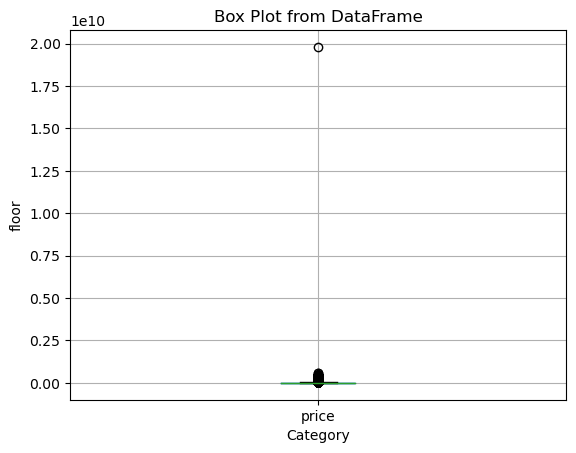

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns

df.boxplot(column=["price"])

# Add labels and title
plt.xlabel('Category')
plt.ylabel('floor')
plt.title('Box Plot from DataFrame')

plt.show()

In [46]:
df[df['price'] == df['price'].max()]

,name,price,Province,area (keat),district,bedroom,bathroom,space,year,type,furniture,floor,distance (m.),station_type,station_name,is_Security,is_Laundry,is_Parking_Lot,is_Bus_Stop,is_Cleaning,is_Fitness,is_Convenient_Store,is_Balcony,is_View,is_Sport_Facility,is_Pool,is_Park,is_Garden,is_corner_room
7076,The Pano Rama 3,1.980000e+10,กรุงเทพ,ยานนาวา,บางโพงพาง,2.0,2.0,137.0,2010.0,ขายขาด,ตกแต่งครบ,34.0,400.0,B6,BRT,True,True,True,False,False,True,False,True,False,True,True,True,False,False


In [ ]:
df.loc[4564, "floor"] = 15 #ตึกไม่สูงพอ
df.loc[2662, "space"] = 605 #ตึกไม่กว้างพอ (เทียบกับห้องอื่นโครงเดียวกัน)
df.loc[7076, "price"] = 19_800_000 #แพงไปไม่มีใครซื้อ

In [ ]:
df.boxplot(column=["floor"])

# Add labels and title
plt.xlabel('Category')
plt.ylabel('floor')
plt.title('Box Plot from DataFrame')

plt.show()

In [ ]:
combined_list = sum(df["name"].astype(str).str.split(',') , [])
set(combined_list)